In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os # s

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12


zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

csv_path = os.path.join(zip_path, 'jena_climate_2009_2016.csv')

df = pd.read_csv(csv_path)

# Xử lý thời gian
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

wv = df['wv (m/s)']
bad_wv = wv == -9999.0
df.loc[bad_wv, 'wv (m/s)'] = 0.0
df.loc[bad_wv, 'max. wv (m/s)'] = 0.0

df_hourly = df[5::6].copy()
df_hourly.set_index('Date Time', inplace=True)

print(f"Kích thước dữ liệu gốc: {df.shape}")
print(f"Kích thước sau khi Resampling (1 giờ/mẫu): {df_hourly.shape}")
df_hourly.head()

Kích thước dữ liệu gốc: (420551, 15)
Kích thước sau khi Resampling (1 giờ/mẫu): (70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [8]:
print("Thống kê mô tả của bộ dữ liệu ban đầu (df):")
print(df.describe())

Thống kê mô tả của bộ dữ liệu ban đầu (df):
                           Date Time       p (mbar)       T (degC)  \
count                         420551  420551.000000  420551.000000   
mean   2012-12-30 06:26:51.498725120     989.212776       9.450147   
min              2009-01-01 00:10:00     913.600000     -23.010000   
25%              2010-12-31 03:25:00     984.200000       3.360000   
50%              2012-12-30 06:20:00     989.580000       9.420000   
75%              2014-12-29 18:55:00     994.720000      15.470000   
max              2017-01-01 00:00:00    1015.350000      37.280000   
std                              NaN       8.358481       8.423365   

            Tpot (K)    Tdew (degC)         rh (%)   VPmax (mbar)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean      283.492743       4.955854      76.008259      13.576251   
min       250.600000     -25.010000      12.950000       0.950000   
25%       277.430000       0.240000      65.21000

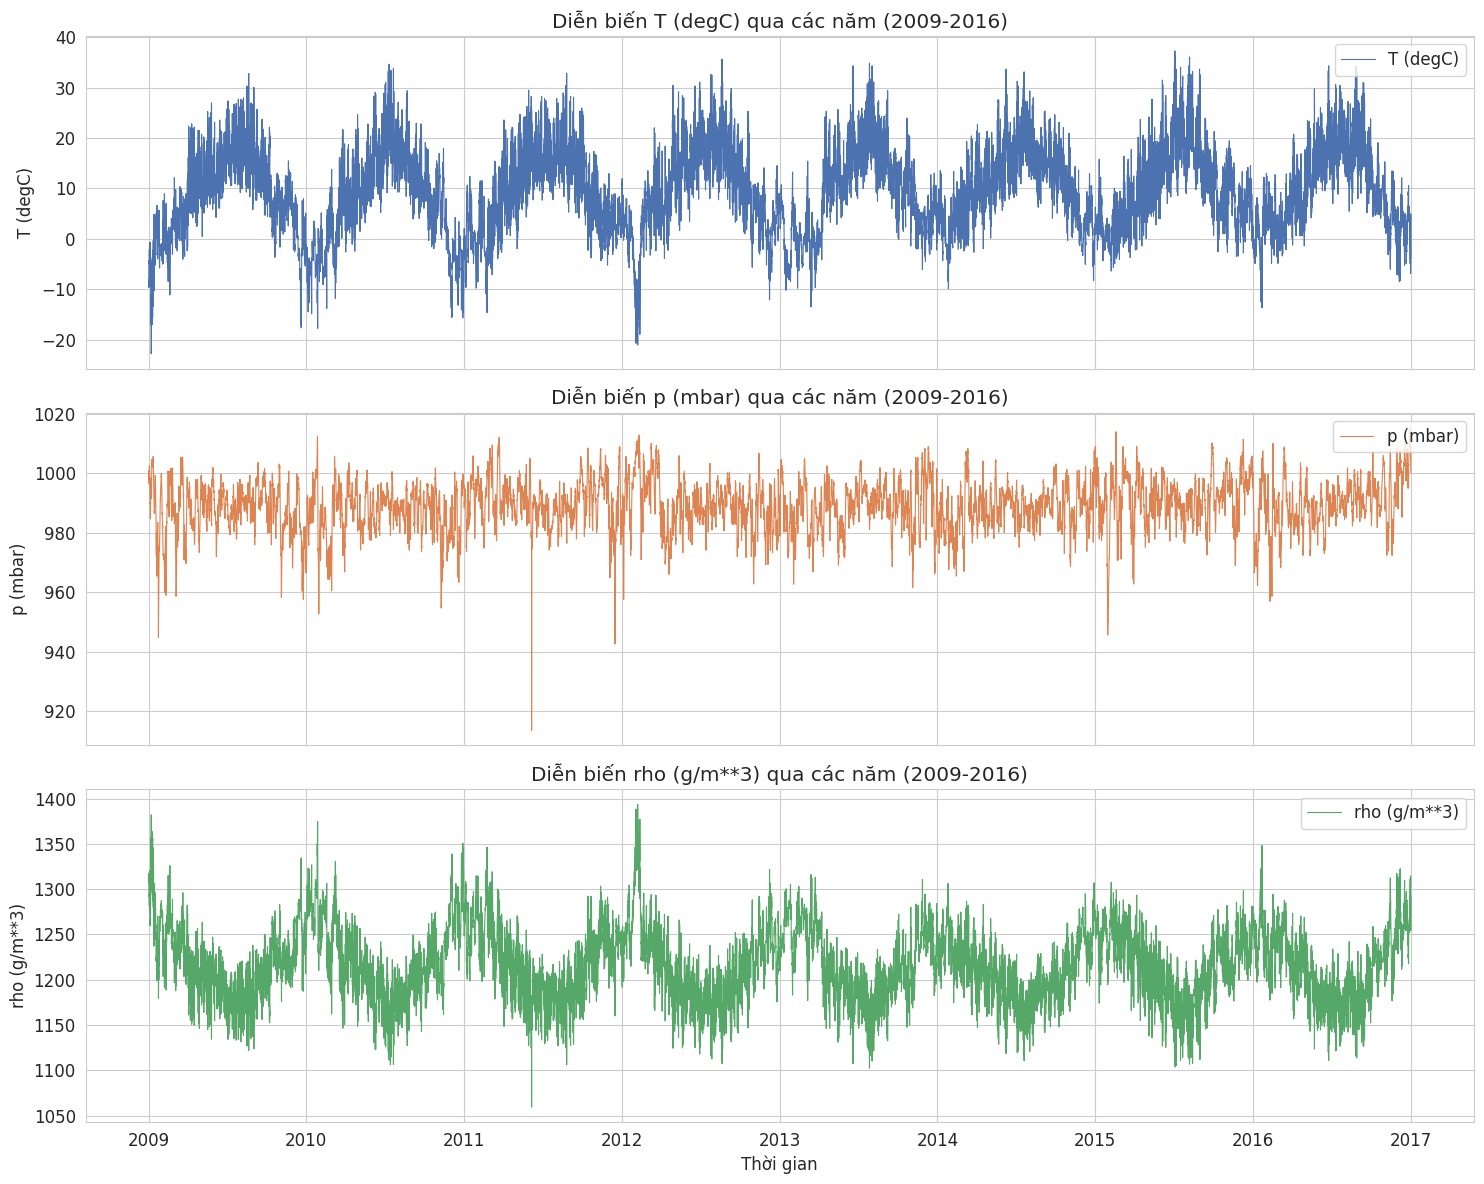

In [9]:
# BIỂU ĐỒ CHUỖI THỜI GIAN GỐC (RAW TIME SERIES)
cols_to_plot = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
features = df_hourly[cols_to_plot]
features.index = df_hourly.index

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
for i, col in enumerate(cols_to_plot):
    axes[i].plot(features[col], label=col, color=sns.color_palette("deep")[i], linewidth=0.8)
    axes[i].set_ylabel(col)
    axes[i].legend(loc='upper right')
    axes[i].set_title(f"Diễn biến {col} qua các năm (2009-2016)")

plt.xlabel("Thời gian")
plt.tight_layout()
plt.show()



In [10]:
# EATMAP TƯƠNG QUAN
plt.figure(figsize=(12, 10))
corr_matrix = df_hourly.corr()



<Figure size 1200x1000 with 0 Axes>

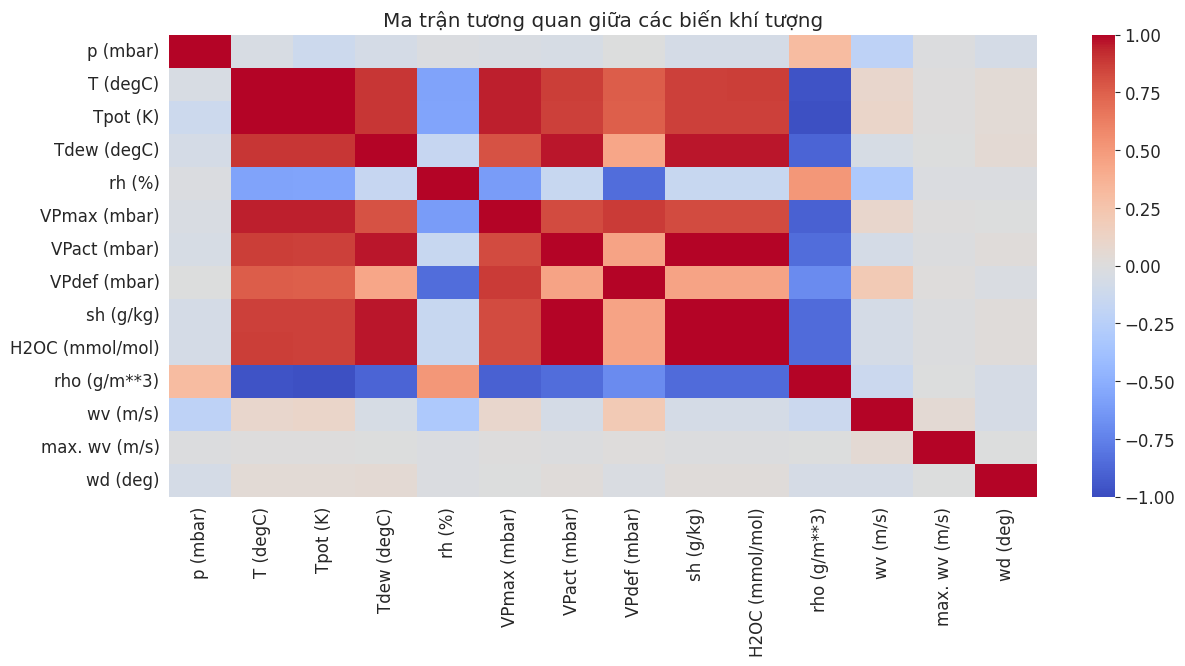

Top biến tương quan với T (degC):
T (degC)           1.000000
Tpot (K)           0.996826
VPmax (mbar)       0.951080
Tdew (degC)        0.895706
VPact (mbar)       0.867691
H2OC (mmol/mol)    0.867195
sh (g/kg)          0.866770
VPdef (mbar)       0.761672
wv (m/s)           0.088506
wd (deg)           0.041577
max. wv (m/s)      0.004363
p (mbar)          -0.045296
rh (%)            -0.572593
rho (g/m**3)      -0.963404
Name: T (degC), dtype: float64


In [11]:
# Vẽ Heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các biến khí tượng")
plt.show()

# In ra các biến tương quan mạnh nhất với Nhiệt độ T (degC)
print("Top biến tương quan với T (degC):")
print(corr_matrix['T (degC)'].sort_values(ascending=False))



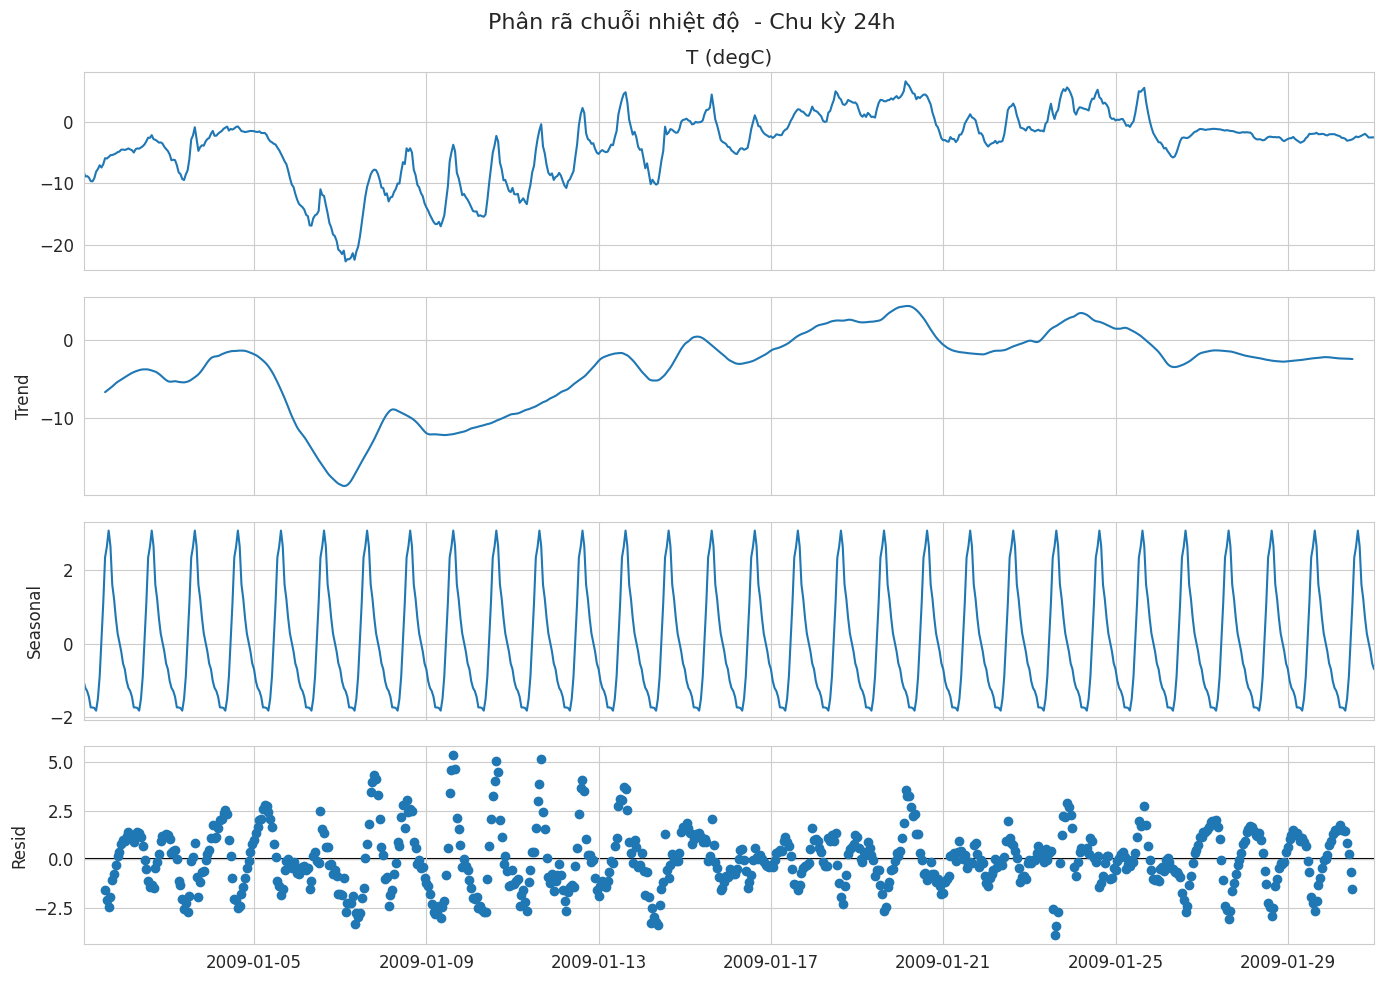

In [12]:
#  PHÂN RÃ CHUỖI THỜI GIAN
subset_idx = 720
decomposition = seasonal_decompose(df_hourly['T (degC)'][:subset_idx], model='additive', period=24)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Phân rã chuỗi nhiệt độ  - Chu kỳ 24h', fontsize=16)
plt.tight_layout()
plt.show()